In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt


2.6383007149418305e-07
1.4977787039695335e-07


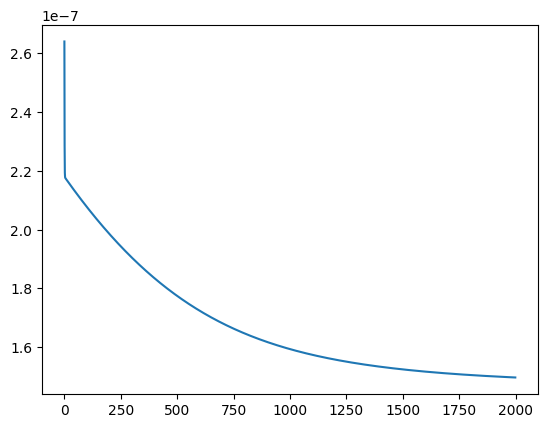

In [2]:
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=int(2e3), loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_n4[0])
print(cost_n4[-1])

plt.plot(cost_n4)

In [3]:
from opentn.transformations import super2choi, choi_composition, partial_transpose
from opentn.optimization import small2zero
from scipy import sparse

# rest of matrices optimized with GSD
X1_gds, X2_gds, X3_gds = xi_n4[-1]
Y2 = X2_gds@X2_gds.conj().T
Y3 = X3_gds@X3_gds.conj().T

# rhs to which we want to approximate
rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
# srhs = sparse.csr_matrix(rhs) # small2zero was deleted
srhs = sparse.csr_matrix(small2zero(rhs, tol=1e-10)) # small2zero was deleted
srhs = srhs.astype(np.float64)

# change partial transpose to A
A = choi_composition(C1=Y2, C2=Y3, dim=dim) # small2zero was deleted
A_tb = partial_transpose(A, dims=[dim, dim], idx=1)
I = np.eye(dim)
A_tbxI = np.kron(A_tb, I)
# sA_tbxI = sparse.csr_matrix(A_tbxI)
sA_tbxI = sparse.csr_matrix(small2zero(A_tbxI, tol=1e-10))
sA_tbxI = sA_tbxI.astype(np.float64)
sA_tbxI

/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self.data.astype(dtype, casting=casting, copy=True),


<4096x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 59136 stored elements in Compressed Sparse Row format>

In [4]:
X_initial = small2zero(X1_gds@X1_gds.conj().T, tol=1e-10).astype(np.float64)

/var/folders/lv/986s3mp97gv9n3rb757bg87m0000gn/T/ipykernel_35125/877660185.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  X_initial = small2zero(X1_gds@X1_gds.conj().T, tol=1e-10).astype(np.float64)


In [5]:
X = cp.Variable((dim**2,dim**2), PSD=True)
lhs =  cp.partial_trace(sA_tbxI @ cp.kron(I, X), dims=[dim, dim, dim], axis=1)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost))
X.value = X_initial
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [6]:
import cvxopt
print(cvxopt.__version__)

1.3.0


In [32]:
prob.solve(solver=cp.SCS, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, eps=1e-11)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 25 02:03:04 AM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 25 02:03:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 25 02:03:04 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 25 02:03:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 25 02:03:04 AM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Jul 25 02:03:04 AM: Finished problem compilation (t

/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jul 25 02:16:14 AM: Problem status: optimal_inaccurate
(CVXPY) Jul 25 02:16:14 AM: Optimal value: 9.514e-08
(CVXPY) Jul 25 02:16:14 AM: Compilation took 1.231e-02 seconds
(CVXPY) Jul 25 02:16:14 AM: Solver (including time spent in interface) took 7.888e+02 seconds


9.514170612735704e-08

In [35]:
print(9.514170612735704e-08/(2.6383007149418305e-07)) # with CVXPY
print(1.4977787039695335e-07/(2.6383007149418305e-07)) # with GDS

0.3606173685529048
0.5677058325788903


In [ ]:
# 2.5956537800015633e-07: with warm start of GDS after 2000 steps

In [5]:
prob.solve(solver=cp.CVXOPT, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 24 08:45:45 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 24 08:45:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 24 08:45:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 24 08:45:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 24 08:45:45 PM: Compiling problem (target solver=CVXOPT).
(CVXPY) Jul 24 08:45:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

OverflowError: number of elements exceeds INT_MAX

In [9]:
# we need to check that the cost function created through cvxpy is the same as with compute_loss, model_Ys, frobenius_norm**2
def cost_cvxpy(C1, C2, rhs, dim):
    I = np.eye(dim)
    C2_tb = partial_transpose(C2, dims=[dim, dim], idx=1)
    C2_tbxI = np.kron(C2_tb, I)
    C2_tbxI = sparse.csr_matrix(C2_tbxI)
    C2_tbxI = C2_tbxI.astype(np.float64)

    srhs = sparse.csr_matrix(rhs) # small2zero was deleted
    srhs = srhs.astype(np.float64)

    lhs =  cp.partial_trace(C2_tbxI @ cp.kron(I, C1), dims=[dim, dim, dim], axis=1)
    cost = cp.norm(lhs - srhs, "fro")
    return cost.value 

# cost_cvxpy(X.value, A, rhs, dim) # it gives the same result but we just have to add the small2zero thing
# would it help not adding the small2zero thing? 

In [12]:
from opentn.transformations import choi2super
print(frobenius_norm(choi_composition(X_initial, A), rhs))
# print(cost_cvxpy(X1opt@X1opt.conj().T, A, rhs, dim))
# check if the cost function would be the same if we used superoperators instead of choi matrices.
# this includes not using sparse matrices
# print(frobenius_norm(choi2super(A)@choi2super(X1opt@X1opt.conj().T), exp_Lvec))

1.4978851472454577e-07


In [48]:
# now we do the same calculations but with the optimal value obtained from cvxpy
tol = 1e-10
print(frobenius_norm(choi_composition(small2zero(X.value, tol=tol), small2zero(A,tol=tol)), small2zero(rhs, tol=tol))) # value when small2zero was used on A and rhs: 2.6522855638959974e-07
# print(cost_cvxpy(X.value, A, rhs, dim))
# similar to above, we use only the superoperators
# print(frobenius_norm(choi2super(A)@choi2super(X.value), exp_Lvec))

# value after warm start and second optimization (using 1e-9): 9.518842518802564e-08

9.514363971597552e-08


In [40]:
# just out of curiosity what happens if we use the third layer to be the same:
print(frobenius_norm(choi2super(X.value)@choi2super(Y2)@choi2super(X.value), exp_Lvec)) # by setting the third layer equal to the first, we loose our gain again, we should optimize over it

2.750144871171991e-07


In [230]:
print(rhs.dtype)
print(X.value.dtype)

complex128
float64


In [80]:
np.linalg.norm(X.value - X1opt@X1opt.conj().T)

3.118308142720801e-07

In [218]:
cost.is_convex()

True

In [41]:
np.linalg.matrix_rank(X.value, tol=1e-9) # 12 up to second optimization with 1e-9 on scs optimizer

12

In [42]:
np.linalg.matrix_rank(X1_gds)

4

In [17]:
X1_gds.shape == X.value.shape == (256, 256)

True

In [18]:
# checking if the matrices we obtained are actually purely real:
# (OLD): if any(x == True for x in np.iscomplex(rhs).flatten())
for op in [X2_gds, X3_gds, Y2, Y3, X1_gds, rhs, A]:
    print(np.linalg.norm(op.imag.flatten()))

0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [44]:
max_idx = 16
print(np.sort(np.linalg.svd(X1_gds@X1_gds.conj().T, compute_uv=False))[::-1][:max_idx])
print('----')
print(np.sort(np.linalg.svd(X.value, compute_uv=False))[::-1][:max_idx])
print('----')
print(np.sort(np.linalg.svd(X1@X1.conj().T, compute_uv=False))[::-1][:max_idx])

[1.59601248e+01 1.99251812e-02 1.99251787e-02 2.48753821e-05
 7.40452593e-15 6.23416821e-15 5.78733966e-15 5.45129161e-15
 5.02854100e-15 4.95731989e-15 4.56542003e-15 4.34589312e-15
 4.19879763e-15 4.02361484e-15 3.80645554e-15 3.57183712e-15]
----
[1.59601248e+01 1.99251773e-02 1.99251750e-02 2.48854583e-05
 5.53631608e-08 4.75044410e-08 4.46950564e-08 4.04994852e-08
 3.85242789e-08 1.87577181e-08 1.34711254e-08 8.16661506e-09
 2.70314397e-10 2.04200850e-10 1.39371188e-10 6.86558966e-11]
----
[1.59601247e+01 1.99252079e-02 1.99252079e-02 2.48753638e-05
 7.95281221e-15 4.45619364e-15 4.15294601e-15 3.74630065e-15
 3.38415367e-15 3.00980011e-15 2.78457911e-15 2.75926410e-15
 2.62875443e-15 2.57327522e-15 2.56723560e-15 2.12727961e-15]


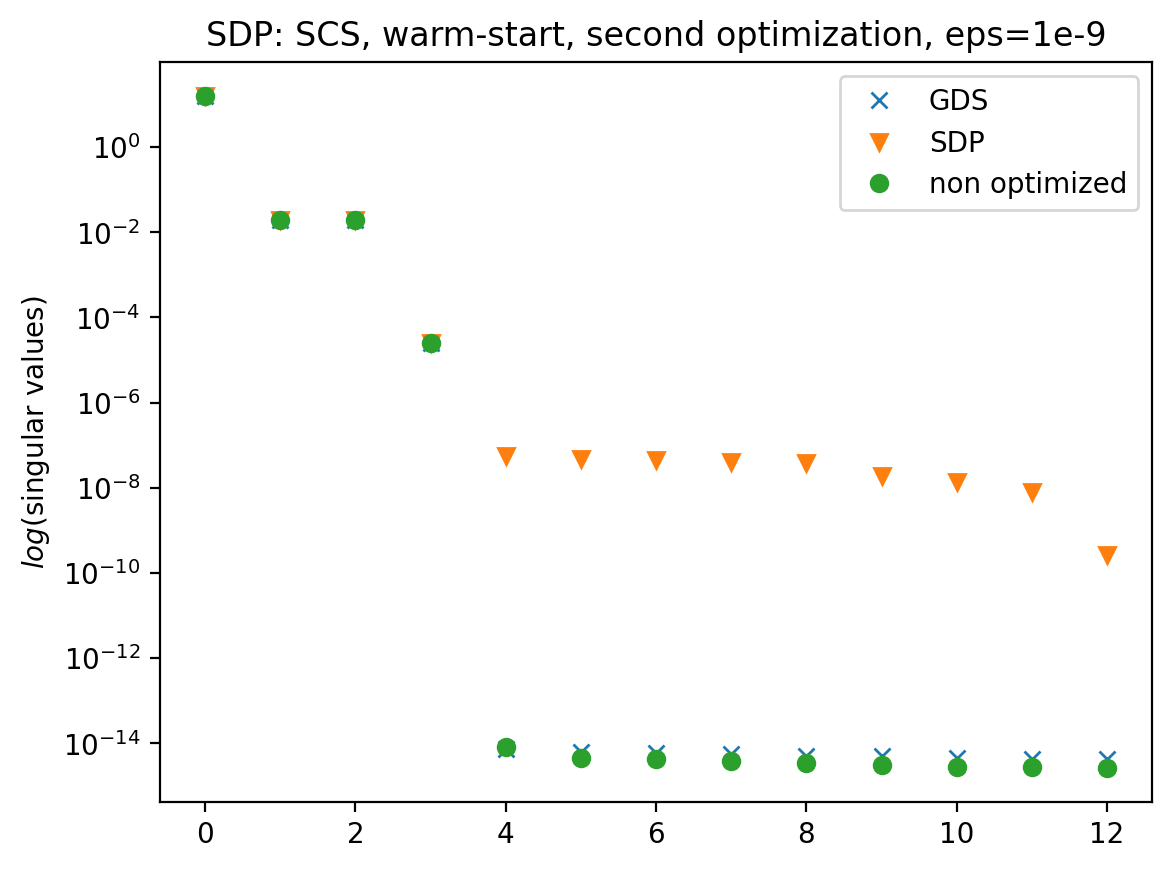

In [31]:
plt.figure(dpi=200)
plt.title('SDP: SCS, warm-start, second optimization, eps=1e-9')
plt.ylabel(f'$log$(singular values)')
plt.semilogy(np.sort(np.linalg.svd(X1_gds@X1_gds.conj().T, compute_uv=False))[::-1][:max_idx], 'x', label='GDS')
plt.semilogy(np.sort(np.linalg.svd(X.value, compute_uv=False))[::-1][:max_idx], 'v', label='SDP')
plt.semilogy(np.sort(np.linalg.svd(X1@X1.conj().T, compute_uv=False))[::-1][:max_idx], 'o', label='non optimized')
plt.legend()


In [46]:
with open('x_scs_warm_gds_eps_e-11.npy', 'wb') as f:
    np.save(f, X.value)

# 24th July:
IDEA: is the configuration of the solver not good enough??
NOTE from workcomputer: random matrices (real and sparse) where taking 
- SCS: 235 min
- MOSEK: 289 min